In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install Bio

In [3]:
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML
import pandas as pd
import re
import matplotlib.pyplot as plt

In [4]:
# read in CSV file
data = pd.read_csv("/content/sample_data/Test.csv")#Change to your path

# remove non-DNA characters from sequence column
data['sequence'] = data['sequence'].apply(lambda x: re.sub("[^ATCG]", "", x))

# extract first 10 oligonucleotide of each sequence, reverse and concatenate to the end
data['reverse'] = data['sequence'].apply(lambda x: x[:10][::-1])
data['sequence'] = data['sequence'] + data['reverse']

In [5]:
print(data.head())

         Name                                           sequence     reverse
0  Circ-FOXO3  GCGGCGGCGGCGGCGCCCGGGAGCCGGAGCCTTCGCGGCGTCCACG...  GGCGGCGGCG


#NCBI BLAST

* The first argument of the qblast function specifies the type of BLAST search to perform. Here are some other options you can use instead of "blastn":

"blastp": Protein vs Protein BLAST
"blastx": Translated query Protein vs nucleotide BLAST
"tblastn": Protein vs Translated nucleotide BLAST
"tblastx": Translated query Protein vs Translated nucleotide BLAST

* The second argument of the qblast function specifies the database to search against. Here are some other options you can use instead of "nt":

"nr": Non-redundant protein sequence database
"refseq_rna": RefSeq RNA sequences
"refseq_genomic": RefSeq genomic sequences
"pdbaa": Protein Data Bank (PDB) amino acid sequences
"env_nr": Non-redundant Environmental samples database

* You can restrict your BLAST search to a specific organism or taxonomic group by using the entrez_query parameter of the qblast function.

entrez_query="Mus musculus [Organism]"

* To restrict your BLAST search to both mouse and microRNAs, you can combine the organism and sequence type information in the entrez_query parameter of the qblast function using the boolean operator "AND".

entrez_query="Mus musculus [Organism] AND microRNA [Sequence Type]"

* To limit your search to all viruses, you can use the NCBI taxonomic identifier for viruses, which is 10239. Here's an example query that would limit your search to all viral sequences:

entrez_query="viruses [Organism]"

#Blast against all viruses

In [70]:
# Define a function to perform the BLAST search and extract the results
def perform_blast(sequence):
    result_handle = NCBIWWW.qblast("blastn", "nt", sequence, expect=10, megablast=False, entrez_query="viruses [Organism]")
    blast_records = NCBIXML.parse(result_handle)
    hitIds = []
    hitLengths = []
    hitPercIdentities = []
    hitEvalues = []
    for blast_record in blast_records:
        for alignment in blast_record.alignments:
            hitIds.append(alignment.hit_id)
            hitLengths.append(alignment.length)
            hitPercIdentities.append(alignment.hsps[0].identities/alignment.length)
            hitEvalues.append(alignment.hsps[0].expect)
    seqResults = pd.DataFrame({'hitId':hitIds, 'hitLength':hitLengths, 'hitPercIdentity':hitPercIdentities, 'hitEvalue':hitEvalues})
    seqResults['QuerySeqName'] = data.loc[data['sequence'] == sequence, 'Name'].iloc[0]
    return seqResults


Virus-this code additionally retrieve start and end position of alined on hit sequences

In [ ]:
# Define a function to perform the BLAST search and extract the results
def perform_blast(sequence):
    result_handle = NCBIWWW.qblast("blastn", "nt", sequence, expect=10, megablast=False, entrez_query="viruses [Organism]")
    blast_records = NCBIXML.parse(result_handle)
    hitIds = []
    hitLengths = []
    hitPercIdentities = []
    hitEvalues = []
    hitStarts = []
    hitEnds = []
    for blast_record in blast_records:
        for alignment in blast_record.alignments:
            for hsp in alignment.hsps:
                hitIds.append(alignment.hit_id)
                hitLengths.append(alignment.length)
                hitPercIdentities.append(hsp.identities/alignment.length)
                hitEvalues.append(hsp.expect)
                hitStarts.append(hsp.sbjct_start)
                hitEnds.append(hsp.sbjct_end)
    seqResults = pd.DataFrame({'hitId':hitIds, 'hitLength':hitLengths, 'hitPercIdentity':hitPercIdentities, 'hitEvalue':hitEvalues, 'hitStart':hitStarts, 'hitEnd':hitEnds})
    seqResults['QuerySeqName'] = data.loc[data['sequence'] == sequence, 'Name'].iloc[0]
    return seqResults


Virus - this code additionally retrieve start and end position of alined on input sequences

In [ ]:
# Define a function to perform the BLAST search and extract the results
def perform_blast(sequence):
    result_handle = NCBIWWW.qblast("blastn", "nt", sequence, expect=10, megablast=False, entrez_query="viruses [Organism]")
    blast_records = NCBIXML.parse(result_handle)
    hitIds = []
    hitLengths = []
    hitPercIdentities = []
    hitEvalues = []
    hitStartPos = []  # new list to store start positions
    hitEndPos = []    # new list to store end positions
    for blast_record in blast_records:
        for alignment in blast_record.alignments:
            hitIds.append(alignment.hit_id)
            hitLengths.append(alignment.length)
            hitPercIdentities.append(alignment.hsps[0].identities/alignment.length)
            hitEvalues.append(alignment.hsps[0].expect)
            hitStartPos.append(alignment.hsps[0].query_start)  # add start position to list
            hitEndPos.append(alignment.hsps[0].query_end)      # add end position to list
    seqResults = pd.DataFrame({'hitId':hitIds, 'hitLength':hitLengths, 'hitPercIdentity':hitPercIdentities, 'hitEvalue':hitEvalues, 'hitStartPos': hitStartPos, 'hitEndPos': hitEndPos})  # add start and end position columns to dataframe
    seqResults['QuerySeqName'] = data.loc[data['sequence'] == sequence, 'Name'].iloc[0]
    return seqResults


virus-this code additionally retrieve aligned sequences

In [ ]:
from Bio import AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

# Define a function to perform the BLAST search and extract the results
def perform_blast(sequence):
    result_handle = NCBIWWW.qblast("blastn", "nt", sequence, expect=10, megablast=False, entrez_query="viruses [Organism]")
    blast_records = NCBIXML.parse(result_handle)
    hitIds = []
    hitLengths = []
    hitPercIdentities = []
    hitEvalues = []
    alignedSeqs = []
    for blast_record in blast_records:
        for alignment in blast_record.alignments:
            hitIds.append(alignment.hit_id)
            hitLengths.append(alignment.length)
            hitPercIdentities.append(alignment.hsps[0].identities/alignment.length)
            hitEvalues.append(alignment.hsps[0].expect)
            # extract aligned sequences
            aligned_seqs = []
            for hsp in alignment.hsps:
                seq_record = SeqRecord(Seq(hsp.sbjct), id=alignment.hit_id)
                aligned_seqs.append(seq_record)
            alignedSeqs.append(aligned_seqs)
    seqResults = pd.DataFrame({'hitId':hitIds, 'hitLength':hitLengths, 'hitPercIdentity':hitPercIdentities, 'hitEvalue':hitEvalues, 'alignedSeq':alignedSeqs})
    seqResults['QuerySeqName'] = data.loc[data['sequence'] == sequence, 'Name'].iloc[0]
    return seqResults

#Mouse mirRNAs

In [79]:
# Import necessary libraries
from Bio.Blast import NCBIXML
from Bio.Blast import NCBIWWW

# Define a function to perform the BLAST search and extract the results
def perform_blast(sequence):
    result_handle = NCBIWWW.qblast("blastn", "nt", sequence, expect=10, megablast=False, entrez_query="Mus musculus [Organism] AND microRNA [Sequence Type]")
    blast_records = NCBIXML.parse(result_handle)
    hitIds = []
    hitLengths = []
    hitPercIdentities = []
    hitEvalues = []
    for blast_record in blast_records:
        for alignment in blast_record.alignments:
            hitIds.append(alignment.hit_id)
            hitLengths.append(alignment.length)
            hitPercIdentities.append(alignment.hsps[0].identities/alignment.length)
            hitEvalues.append(alignment.hsps[0].expect)
    seqResults = pd.DataFrame({'hitId':hitIds, 'hitLength':hitLengths, 'hitPercIdentity':hitPercIdentities, 'hitEvalue':hitEvalues})
    seqResults['QuerySeqName'] = data.loc[data['sequence'] == sequence, 'Name'].iloc[0]
    return seqResults

Running time for the following code depends on the number of your sequences in csv file and their length. The running time is vary from a few minutes to hours. Be patient!

In [80]:
# Use apply to apply the function to each sequence in the data frame
results_list = [perform_blast(seq) for seq in data['sequence']]

In [81]:
# Combine the results into a single data frame
results = pd.concat(results_list)

In [ ]:
# Save the DataFrame as a CSV file
results.to_csv('/content/sample_data/result.csv', index=False)#Change to your path

In [82]:
# Split the values in Column1 into three separate columns
results[['Col1','gi_number', 'Col3', 'ref_num']] = results['hitId'].str.split('|', n=3, expand=True)

# Remove the last character from the 'City' column
results['ref_num'] = results['ref_num'].str.rstrip('|')


Enter the retrieve gi number (https://www.ncbi.nlm.nih.gov/nuccore/508728658) to get more information

In [83]:
print(results.head())

                            hitId  hitLength  hitPercIdentity     hitEvalue  \
0     gi|530410066|gb|JX912274.1|       3793         0.041919  1.432090e-28   
1    gi|84781798|ref|NM_172468.2|       7507         0.006394  1.176570e-10   
2  gi|1450320917|ref|NM_177239.3|       7419         0.007818  4.106640e-10   
3   gi|224922750|ref|NM_173437.2|      12767         0.003760  5.002910e-09   
4  gi|1917882354|ref|NG_068085.2|      16184         0.003213  1.746190e-08   

  QuerySeqName Col1   gi_number Col3      ref_num  
0   Circ-FOXO3   gi   530410066   gb   JX912274.1  
1   Circ-FOXO3   gi    84781798  ref  NM_172468.2  
2   Circ-FOXO3   gi  1450320917  ref  NM_177239.3  
3   Circ-FOXO3   gi   224922750  ref  NM_173437.2  
4   Circ-FOXO3   gi  1917882354  ref  NG_068085.2  


Organism name

In [ ]:
from Bio import Entrez

Entrez.email = "your.email@example.com" # Enter your email address here

def get_gene_symbol(ref_num):
    handle = Entrez.efetch(db="nucleotide", id=ref_num, rettype="gb", retmode="xml")
    records = Entrez.read(handle, validate=False)
    handle.close()
    try:
        gene_symbol = records[0]['GBSeq_feature-table'][0]['GBFeature_quals'][0]['GBQualifier_value']
    except KeyError:
        gene_symbol = ref_num
    return gene_symbol

# Let's say your dataframe is called 'results' and the column with NCBI reference numbers is called 'ref_num'
df['gene_symbol'] = df['ref_num'].apply(get_gene_symbol)

Sequence type

In [66]:
from Bio import Entrez

Entrez.email = "your.email@example.com" # Enter your email address here

def get_gene_symbol(ref_num):
    handle = Entrez.efetch(db="nucleotide", id=ref_num, rettype="gb", retmode="xml")
    records = Entrez.read(handle, validate=False)
    handle.close()
    try:
        gene_symbol = records[0]['GBSeq_feature-table'][0]['GBFeature_quals'][0]['GBQualifier_value']
        if gene_symbol == records[0]['GBSeq_organism']:
            # if the extracted gene symbol is the same as the organism name,
            # try to extract the gene symbol from the 'gene' tag instead
            gene_symbol = records[0]['GBSeq_feature-table'][0]['GBFeature_quals'][1]['GBQualifier_value']
    except KeyError:
        gene_symbol = ref_num
    return gene_symbol

# Let's say your dataframe is called 'results' and the column with NCBI reference numbers is called 'ref_num'
results['gene_symbol'] = results['ref_num'].apply(get_gene_symbol)

Gene Symbol

In [84]:
from Bio import Entrez

Entrez.email = "your.email@example.com" # Enter your email address here

def get_gene_symbol(ref_num):
    handle = Entrez.efetch(db="nucleotide", id=ref_num, rettype="gb", retmode="xml")
    records = Entrez.read(handle, validate=False)
    handle.close()

    # Try to extract gene symbol from gene feature
    for feature in records[0]['GBSeq_feature-table']:
        if feature['GBFeature_key'] == 'gene':
            gene_symbol = feature['GBFeature_quals'][0]['GBQualifier_value']
            return gene_symbol

    # Try to extract gene symbol from protein feature
    for feature in records[0]['GBSeq_feature-table']:
        if feature['GBFeature_key'] == 'CDS':
            if 'gene' in feature['GBFeature_quals'][0].values():
                gene_symbol = feature['GBFeature_quals'][0]['GBQualifier_value']
                return gene_symbol

            for qualifier in feature['GBFeature_quals']:
                if qualifier['GBQualifier_name'] == 'product':
                    gene_symbol = qualifier['GBQualifier_value']
                    return gene_symbol

    # Try to extract gene symbol from sequence description
    description = records[0]['GBSeq_definition']
    if 'gene=' in description:
        gene_symbol = description.split('gene=')[1].split(']')[0]
        return gene_symbol

    # If no gene symbol found, return the original reference number
    return ref_num

# Let's say your dataframe is called 'results' and the column with NCBI reference numbers is called 'ref_num'
results['gene_symbol'] = results['ref_num'].apply(get_gene_symbol)


In [85]:
print(results.head())

                            hitId  hitLength  hitPercIdentity     hitEvalue  \
0     gi|530410066|gb|JX912274.1|       3793         0.041919  1.432090e-28   
1    gi|84781798|ref|NM_172468.2|       7507         0.006394  1.176570e-10   
2  gi|1450320917|ref|NM_177239.3|       7419         0.007818  4.106640e-10   
3   gi|224922750|ref|NM_173437.2|      12767         0.003760  5.002910e-09   
4  gi|1917882354|ref|NG_068085.2|      16184         0.003213  1.746190e-08   

  QuerySeqName Col1   gi_number Col3      ref_num  gene_symbol  
0   Circ-FOXO3   gi   530410066   gb   JX912274.1         GFAP  
1   Circ-FOXO3   gi    84781798  ref  NM_172468.2        Snx30  
2   Circ-FOXO3   gi  1450320917  ref  NM_177239.3        Mysm1  
3   Circ-FOXO3   gi   224922750  ref  NM_173437.2         Nav1  
4   Circ-FOXO3   gi  1917882354  ref  NG_068085.2  NG_068085.2  


# Visualization

You can change "x = 'ref_num' to 'gene_symbol' to show the result in genesymbol

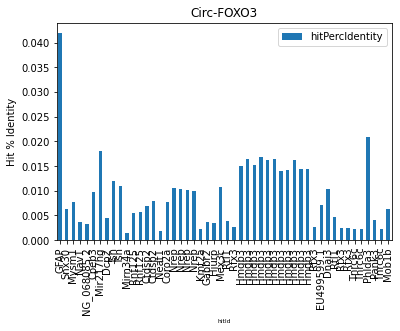

In [86]:
# Create a bar chart for each sequence using groupby
results.groupby('QuerySeqName').apply(lambda x: x.plot.bar(x='ref_num', y='hitPercIdentity', title=x.name))
ax = plt.gca()
ax.set_xlabel('hitId', fontsize=6)
ax.set_ylabel('Hit % Identity', fontsize=10)
#ax.set_title(x.name, fontsize=12)
# Show the charts
plt.show()

This code can save your graphs with publication quality in your path of interest

In [ ]:
import os
import matplotlib.pyplot as plt

# Define the dpi size and save path
dpi = 300
save_path = os.path.join(os.getcwd(), 'path/')

# Create the save path directory if it doesn't exist
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6), dpi=dpi)

# Group the results by query sequence name and plot a bar chart for each group
for name, group in results.groupby('QuerySeqName'):
    group.plot.bar(x='ref', y='hitPercIdentity', title=name, ax=ax)
    
    # Set the x and y axis labels
    ax.set_xlabel('hitId', fontsize=6)
    ax.set_ylabel('Hit % Identity', fontsize=10)
    
    # Set the title
    ax.set_title(name, fontsize=12)
    
    # Save the figure in the desired format and location
    fig.savefig(os.path.join(save_path, f"{name}.png"), dpi=dpi)

# Show the charts
plt.show()


To have all graphs in one figure, run this code! you need to adjust number of rows and columns.

In [ ]:
import matplotlib.pyplot as plt

# Determine the number of rows and columns needed for the bar charts
# Change nrows and ncols based on your output images
nrows = 4
ncols = 3

# Create a figure with the specified number of rows and columns
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 16))

# Loop through each unique query sequence name
for i, name in enumerate(results['QuerySeqName'].unique()):
    # Calculate the row and column index for this query sequence
    row_idx = i // ncols
    col_idx = i % ncols
    
    # Select data for this query sequence
    data = results.loc[results['QuerySeqName'] == name]
    
    # Add the bar chart for this query sequence to the corresponding subplot
    data.plot.bar(x='hitId', y='hitPercIdentity', title=name, ax=axes[row_idx, col_idx])
    
    # Hide the x-axis ticks and labels for all subplots
    axes[row_idx, col_idx].set_xticks([])
    axes[row_idx, col_idx].set_xticklabels([])
    
    # Remove the x-axis legend
    axes[row_idx, col_idx].legend().remove()
    
    # Adjust the layout of the subplot
    axes[row_idx, col_idx].autoscale(enable=True, axis='both', tight=True)
    axes[row_idx, col_idx].margins(0.05)
    
# Adjust the layout of the subplots
fig.tight_layout()

# Show the figure
plt.show()
